# Sentiments towards COVID-19 Vaccine in South Africa _Embedding training

## Background
What were we trying to achieve? What are the key results/insights did we obtain? How did we get to these insights? What data was used and how was it processed? 

In [1]:
# Importing useful packages
import pandas as pd
import numpy as np
import nltk
from nltk.stem import PorterStemmer 

from nltk.tokenize import word_tokenize 
#from stop_words import get_stop_words
#import re"
#from english_words import english_words_set
from collections import Counter
import matplotlib.pyplot as plt
#import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
#nltk.download(Stopwords)
#Embedding dependencies
import gensim
from gensim.models import word2vec
import multiprocessing
import random

In [2]:
random.seed(2)

In [3]:
# Normalizing data
from sklearn.preprocessing import StandardScaler
standard = StandardScaler()

In [4]:
# Reading dataframes with tokenized sentences for training word embeddings
df_replies = pd.read_csv('replies_dataframe.csv').drop('Unnamed: 0',axis =1)
df_comments = pd.read_csv('comments_dataframe.csv').drop('Unnamed: 0',axis =1)
df_gates = pd.read_csv('gates_dataframe.csv').drop('Unnamed: 0',axis =1)

In [5]:
# Retrieving the tokenized sentences for embedding training
replies_retrieved = [list(df_replies.iloc[i].dropna().astype('str')) for i in range(df_replies.shape[0])]
comments_retrieved = [list(df_comments.iloc[i].dropna().astype('str')) for i in range(df_comments.shape[0])]
gates_retrieved = [list(df_gates.iloc[i].dropna().astype('str')) for i in range(df_gates.shape[0])]

In [6]:
def clean_emp_sentences(sentences):
     return [sentences[i]  for i in range(len(sentences)) if len(sentences[i]) > 0]



In [7]:
def embedding_trainer(sentences,min_count,window,sg = 1):
    sent = clean_emp_sentences(sentences)
    embedding = word2vec.Word2Vec(sentences = sent,min_count = min_count,window=window,sg = 1)
    word_vectors = embedding.wv
    return word_vectors

    

In [8]:
def top_closest(word_vecs,interest_word,n):
    '''Printing the top n closest words to a word of interest'''
    closewords = word_vecs.similar_by_word(interest_word)
    print(f'Most similar to vaccine are {closewords[:n]}')

In [9]:
reply_vectors = embedding_trainer(replies_retrieved,35,5)
top_closest(reply_vectors,'vaccine',5)

Most similar to vaccine are [('virus', 0.9995299577713013), ('give', 0.9994684457778931), ('probably', 0.9994585514068604), ('safe', 0.9994472861289978), ('yes', 0.9994359016418457)]


In [10]:
comment_vectors = embedding_trainer(comments_retrieved,19,5)
top_closest(comment_vectors,'vaccine',5)

Most similar to vaccine are [('virus', 0.9995870590209961), ('get', 0.9995759129524231), ('give', 0.999567985534668), ('flu', 0.9995439648628235), ('Covid', 0.9995421171188354)]


In [11]:
combined_vectors = embedding_trainer(replies_retrieved + comments_retrieved,53,5)
top_closest(combined_vectors,'vaccine',5)


Most similar to vaccine are [('virus', 0.9994125366210938), ('safe', 0.9993777871131897), ('taking', 0.9993696212768555), ('first', 0.9993686676025391), ('get', 0.9993640780448914)]


In [12]:
gates_vectors = embedding_trainer(gates_retrieved,13,5)
top_closest(gates_vectors,'vaccine',5)


Most similar to vaccine are [('ingredients', 0.9994663000106812), ('virus', 0.9994365572929382), ('Africa', 0.9994297027587891), ('countries', 0.999417245388031), ('Leaders', 0.9994118213653564)]


## Plotting the embedding dimensions with PCA

In [13]:
def pca(df):
    #Computing the correlation matrix
    X_corr=df.corr()

    #Computing eigen values and eigen vectors
    values,vectors=np.linalg.eig(X_corr)

    #Sorting the eigen vectors coresponding to eigen values in descending order
    args = (-values).argsort()
    values = vectors[args]
    vectors = vectors[:, args]

    #Taking first 2 components which explain maximum variance for projecting
    new_vectors=vectors[:,:2]

    #Projecting it onto new dimesion with 2 axis
    neww_X=np.dot(df.values,new_vectors)
    return neww_X

In [14]:
# Plotting function
def plotting_components_mod(components,model, no_words = 30,data_name=''):
    """no_words: The number of words you want to display on visualization"""
    plt.figure(figsize=(13,7))
    plt.scatter(components[:no_words,0],components[:no_words,1],linewidths=10,color='blue')
    plt.xlabel("PC1",size=15)
    plt.ylabel("PC2",size=15)
    plt.title(f"Top {no_words} words in the {data_name} embedding space",size=20)
    vocab=list(model.wv.vocab)[:no_words]
    for i, word in enumerate(vocab):
        if word == 'vaccine':
            plt.scatter(components[i,0],components[i,1],linewidths=10,color='red')
            plt.annotate(word,xy=(components[i,0],components[i,1]),fontsize=14)
        #elif word in ['Africa', 'Gates', 'I', 'They', 'You', 'get', 'trial','world']:            
        #    plt.scatter(components[i,0],components[i,1],linewidths=10,color='green')
        #    plt.annotate(word,xy=(components[i,0],components[i,1]),fontsize=14)
        else:
            plt.annotate(word,xy=(components[i,0],components[i,1]),fontsize=14)



In [15]:
# Plotting function for words around a word of intefontsize=sizerest
def plotting_components(components,words_for_plot,data_name=''):
    plt.figure(figsize=(13,7))
    plt.scatter(components[0,0],components[0,1],linewidths=10,color='red')
    plt.scatter(components[1:,0],components[1:,1],linewidths=10,color='blue')
    plt.xlabel("PC1",size=15)
    plt.ylabel("PC2",size=15)
    plt.title(f"Top 20 closest words to Gates in the {data_name} embedding space",size=20)    #vocab=list(model.wv.vocab)
    for i, word in enumerate(words_for_plot):
        plt.annotate(word,xy=(components[i,0],components[i,1]),fontsize=16)



In [16]:
# Obtaining the common words from all the three embedding plots of the top n_words of each embedding
def common_words(embeddings_list,no_words):
    vocabs = []
    for embed in embeddings_list:
        vocab=list(embed.wv.vocab)[:no_words]
        vocabs.append(set(vocab))
    commons = vocabs[0]
    for i in range(len(vocabs)-1):
        commons = commons.intersection(vocabs[i+1])
    return commons
    #commons = [commons.intersection(vocabs[i+1]) for i in range(len(embeddings_list -1))]

In [17]:
#embeddings_list = [reply_vectors,comment_vectors,combined_vectors]
# obtaining the common words in these embeddings from the top 30 words
#common_words(embeddings_list,31)

## Plotting the n close words to our word of interest 'Vaccine'. 

In [18]:
# printing the learnt vocabulary
reply_words=list(reply_vectors.wv.vocab)
comment_words=list(comment_vectors.wv.vocab)
combined_words=list(combined_vectors.wv.vocab)


In [19]:
def word_distribution_around_target_word(target_word,n_surrounding_words,word_embeddings,data_name=''):
    """Function to pick the desired number of surrounding words around a word of interest to understand
    its contextual associations.
    Inputs:
    target_word: The word with whose contextual assications you'd want to understand
    n_surrounding_words: The n clossest words to the target word in the embedding dimension
    word_embeddings: word embeddings from gensim """
    
    surrounding_words = [word_embeddings.similar_by_word(target_word,topn = n_surrounding_words)[i][0] for i in range(n_surrounding_words)]
    words_for_plot = [target_word] + surrounding_words 
    X  = word_embeddings[words_for_plot]
    #Standardize for PCA
    X_standard = standard.fit_transform(X)
    #Creating dataframes with words as index and columns representing each embedding dimension
    df = pd.DataFrame(X_standard,index=words_for_plot)
    # PCA on dataframe
    components = pca(df)
    plotting_components(components,words_for_plot,data_name)

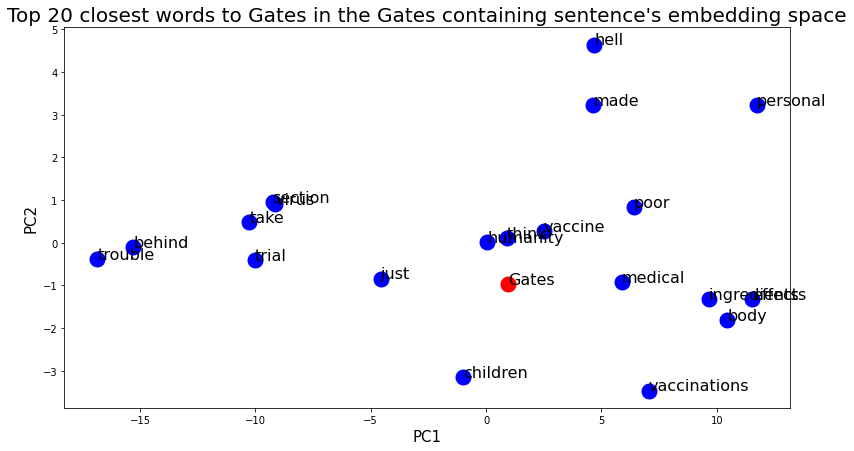

In [20]:
# Plot for words around vaccine in the replies corpus
word_distribution_around_target_word('Gates',20,gates_vectors,"Gates containing sentence's")

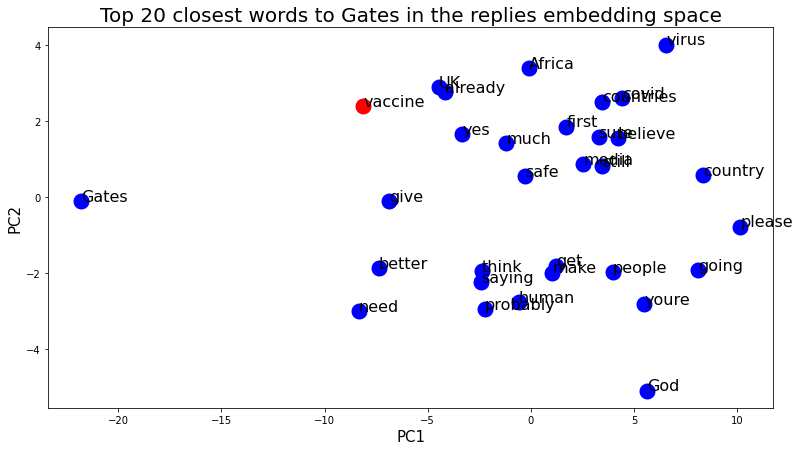

In [21]:
# Plot for words around vaccine in the replies corpus
word_distribution_around_target_word('vaccine',30,reply_vectors,'replies')

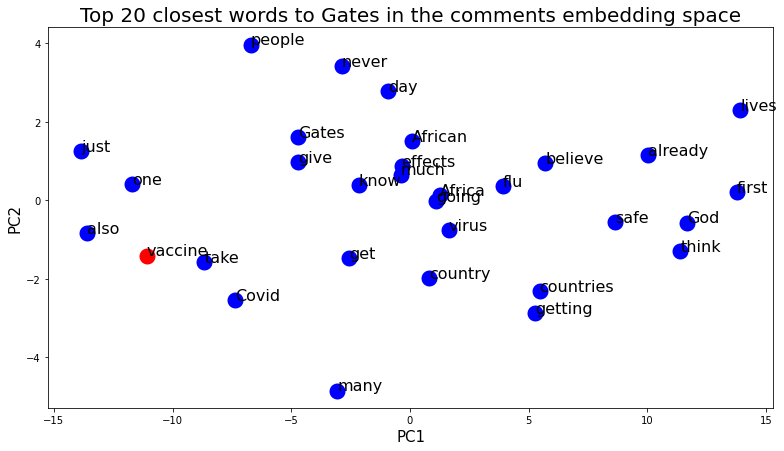

In [22]:
# Plot for words around vaccine in the comments corpus
word_distribution_around_target_word('vaccine',30,comment_vectors,'comments')

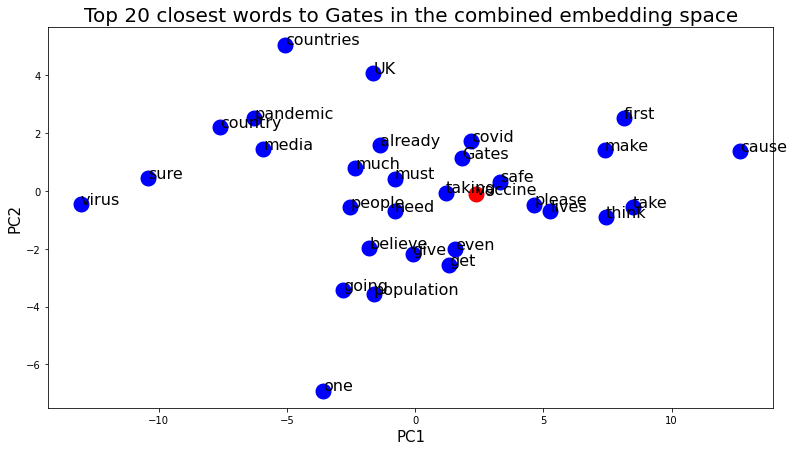

In [23]:
# Plot for words around vaccine in the combined corpus
word_distribution_around_target_word('vaccine',30,combined_vectors,'combined')

In [24]:
# count of words in the embedding space
def embedding_vocab_count(vectors):
    return len(list(vectors.wv.vocab))

In [25]:
# replies
embedding_vocab_count(reply_vectors)

102

In [26]:
#comments
embedding_vocab_count(comment_vectors)

103

In [27]:
# combined
embedding_vocab_count(combined_vectors)

100

In [29]:
embedding_vocab_count(gates_vectors)

102

In [30]:
#word_distribution_around_target_word('Gates',10,gates_vectors,'gates')